# Comparaison of regression lines and analysis of covariance

## 1. Introduction

Previously, we discussed simple linear regression which involves fitting a straight line to a number of points using the method of least squares. In this chapter we show how to compare two or more regression lines. We also show how this technique can be used with analysis of variance to control experimental error, a method called analysis of covariance.

## 2. Comparison of two regression lines

Here we describe how to test whether regression lines fitted to two independent sets of data are parallel. Using the two independent estimates of slope $\hat{\beta_1}$, $\hat{\beta_2}$ based on $n_1$ and $n_2$ observations, you wish to test the hypothesis that $\hat{\beta_1} = \hat{\beta_2}$. If you can assume parallel lines you can go on to test whether the intercepts are equal. If they are you can fit an overall line to the data.

In our working example, a greenhouse experiment was carried out to investigate the response of strawberry to two types of fertiliser (F1 and F2). Four plants were grown in each pot and twelve pots were treated at random with each fertiliser. At harvest time various measurements were made on each pot, but for this example we are only interested in the total fruit dry weight (X) and the total leaf area (Y).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, f, probplot, linregress, levene

In [2]:
#dataframe of experimental data
data = pd.DataFrame({'fertiliser':[1 for _ in range(12)] + [2 for _ in range(12)],
                     'X':[0.29, 0.43, 0.21, 0.53, 0.27, 0.33, 0.47, 0.40, 0.48, 0.30, 0.37, 0.30,
                          0.27, 0.37, 0.42, 0.19, 0.30, 0.25, 0.35, 0.48, 0.22, 0.30, 0.14, 0.32],
                     'Y':[144, 180, 60, 226, 105, 111, 217, 221, 218, 137, 153, 105,
                          129, 206, 172, 80, 124, 89, 134, 220, 138, 105, 62, 181]})

### 2.1 Testing for equality of slopes

To test the hypothesis that $\hat{\beta_1} = \hat{\beta_2}$ carry out a t-test by calculating $t = (\hat{\beta}_1 - \hat{\beta}_2) \: / \: SED$ and calculate a p-value on $n_1 + n_2 - 4$ degrees of freedom where SED is the standard error of the difference between the two fitted slopes.

$$ SED = \sqrt{s_p^2 \left( \frac{1}{S_{xx1}} + \frac{1}{S_{xx2}} \right)} $$

$$ s_p^2 = \frac{ResidSS_1 + ResidSS_2}{(n_1 - 2) + (n_2 - 2)} $$

$s_p^2$ is an estimate of the assumed common population residual variance. When $n_1 = n_2$ this is the average of the two residual mean squares $RMS_1$ and $RMS_2$. To test the assumption of common population variance you divide the larger RMS by the smaller to obtain an F-value and then calculate a p-value on $n - 2$ degrees of freedom.

Testing the equality of slopes

t-value : 0.775
p-value : 0.22365


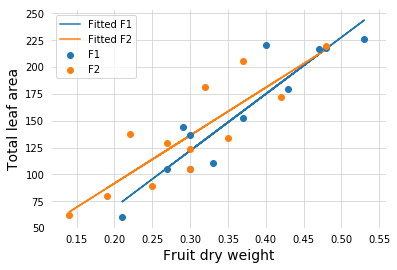

In [3]:
#get x and y values for the two treatments
X1 = data[data['fertiliser']==1]['X']
X2 = data[data['fertiliser']==2]['X']
Y1 = data[data['fertiliser']==1]['Y']
Y2 = data[data['fertiliser']==2]['Y']

#sample size
n1 = len(data[data['fertiliser']==1])
n2 = len(data[data['fertiliser']==2])

#degrees of freedom
df1 = n1 - 2
df2 = n2 - 2
df_resid = df1 + df2

#get sum of squares
Sxx1 = X1.var() * (n1 - 1)
Sxx2 = X2.var() * (n2 - 1)

#perform  linear regression
slope1, intercept1, rval1, pval1, stderr1 = linregress(X1, Y1)
slope2, intercept2, rval2, pval2, stderr2 = linregress(X2, Y2)

#fitted values
Y1_fit = X1 * slope1 + intercept1
Y2_fit = X2 * slope2 + intercept2

#residual sum of squares
resid_ss1 = np.sum((Y1 - Y1_fit) ** 2)
resid_ss2 = np.sum((Y2 - Y2_fit) ** 2)

#residual mean squares
resid_ms1 = resid_ss1 / df1
resid_ms2 = resid_ss2 / df2

#common population residual variance
sp2 = (resid_ss1 + resid_ss2) / (n1 + n2 - 4)

#standard error of the difference between the slopes
sed = np.sqrt(sp2 * (1 / Sxx1 + 1 / Sxx2))

t_val = (slope1 - slope2) / sed

p_val = 1 - t.cdf(abs(t_val), df_resid)

fig, ax = plt.subplots()
ax.scatter(X1, Y1, label='F1', zorder=5)
ax.scatter(X2, Y2, label='F2', zorder=5)
ax.plot(X1, X1 * slope1 + intercept1, label='Fitted F1', zorder=4)
ax.plot(X2, X2 * slope2 + intercept2, label='Fitted F2', zorder=4)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)
ax.grid(color='lightgrey')
ax.tick_params(axis='both', color='white')
ax.set_xlabel('Fruit dry weight', fontsize=14)
ax.set_ylabel('Total leaf area', fontsize=14)
plt.legend()

print('Testing the equality of slopes\n')
print('t-value : {:.3f}'.format(t_val))
print('p-value : {:.5f}'.format(p_val))

The p-value for the test that the slopes are equal is 0.22 so we cannot reject this hypothesis. The data are thus in agreement with the hypothesis of a common slope. The estimate for the common slope is:

$$  \hat{\beta} = \frac{S_{xy1} + S_{xy2}}{S_{xx1} + S_{xx2}} $$

We can assume that the lines have a common slope, but it does not necessarily imply they are identical, only that they are parallel. You can only use the overall fitted line if  you can also show that the intercepts are not significantly different. Assuming a common slope the two intercepts are estimated as:

$$ \hat{\alpha}_1 = \bar{Y}_1 - \hat{\beta} \bar{X}_1 $$
$$ \hat{\alpha}_2 = \bar{Y}_2 - \hat{\beta} \bar{X}_2 $$

In [4]:
#estimated slope
Sxy1 = np.dot(X1, Y1) - X1.sum() * Y1.sum() / len(X1)
Sxy2 = np.dot(X2, Y2) - X2.sum() * Y2.sum() / len(X2)
slope = (Sxy1 + Sxy2) / (Sxx1 + Sxx2)

#estimated intercepts
intercept1 = Y1.mean() - slope * X1.mean()
intercept2 = Y2.mean() - slope * X2.mean()
print('Estimated intercept 1 : {:.3f}'.format(intercept1))
print('Estimated intercept 2 : {:.3f}'.format(intercept2))

Estimated intercept 1 : -21.670
Estimated intercept 2 : -10.113


### 2.2 Test for equality of intercepts

It only makes sense to compare the intercepts if the lines are parallel. When they are parallel, a test of equality of intercepts is a test of the difference in elevations of the two lines.

To test the hypothesis that $\alpha_1 = \alpha_2$ carry out a t-test by calculating $t = (\hat{\alpha}_1 - \hat{\alpha}_2) \:/ \: SED$ and calculate a p-value on $n_1 + n_2 - 3$ degrees of freedom where SED is the standard error of the difference between the two fitted intercepts. Its formula is:

$$ SED = \sqrt{s_{yx}^2 \left( \frac{1}{n_1} + \frac{1}{n_2} + \frac{\left( \bar{X}_1 - \bar{X}_2 \right) ^2}{S_{xx1} + S_{xx2}} \right)} $$

$$s_{yx}^2 = \frac{S_{yy1} + S_{yy2} - \left( S_{xy1} + S_{xy2} \right) ^2 \: / \: \left( S_{xy1} + S_{xy2} \right)}{n_1 + n_2 - 3} $$

In [5]:
#testing if intercept1 = intercept2

#sum of squares for Y values
Syy1 = Y1.var() * (n1 - 1)
Syy2 = Y2.var() * (n2 - 1)

#standard error of the difference
syx2 = (Syy1 + Syy2 - (Sxy1 + Sxy2) ** 2 / (Sxx1 + Sxx2)) / (n1 + n2 - 3)
sed_intercept = np.sqrt(syx2 * (1 / n1 + 1 / n2 + (X1.mean() - X2.mean()) ** 2 / (Sxx1 + Sxx2)))

#t and p values
t_val = (intercept1 - intercept2) / sed_intercept
p_val = 1 - t.cdf(abs(t_val), n1 + n2 - 3)

print('Test the equality of intercepts\n')
print('t-value : {:.3f}'.format(t_val))
print('p-value : {:.5f}'.format(p_val))

Test the equality of intercepts

t-value : -1.115
p-value : 0.13880


### 2.3 The adjusted Y means

Assuming equal slopes, the difference between the intercepts is the same as the difference between the fitted Y values when $x = \bar{X}$, the overall X mean. We show this as follows. The fitted equation of line one and two are:

$$ Y_1 = \hat{\alpha}_1 + \hat{\beta} X = \left( \bar{Y}_1 -\hat{\beta}\bar{X}_1 \right) + \hat{\beta} X = \bar{Y}_1 - \hat{\beta} \left( \bar{X}_1 - X \right) $$

$$ Y_2 = \hat{\alpha}_2 + \hat{\beta} X = \left( \bar{Y}_2 -\hat{\beta}\bar{X}_2 \right) + \hat{\beta} X = \bar{Y}_2 - \hat{\beta} \left( \bar{X}_2 - X \right) $$

In [6]:
Y1_fitted = Y1.mean() - slope * (X1.mean() - data['X'].mean())
Y2_fitted = Y2.mean() - slope * (X2.mean() - data['X'].mean())
print('Difference between fitted Y means : {:.3f}'.format(Y1_fitted - Y2_fitted))

Difference between fitted Y means : -11.558


The difference between the fitted Y means is the difference between the intercepts. Thus a test of this difference is a test of the difference between the adjusted Y means. The calculations involved are part of the analysis of covariance, which enables several regression lines to be compared.

## 3. Analysis of covariance (ANCOVA)

The technique of analysis of covariance can be applied to all the common experimental designs to increase the precision of treatment comparisons. A covariate X is measured on the same experimental units as the yield Y. The treatment means are adjusted to what it is estimated they would have been if all the treatments had the same mean X value, and the adjusted treatment means are compared. The amount of adjustment depends on the form of relationship between the Y and X values. It is most commonly assumed that this relationship is linear and the slope is the same for each treatment. It is further assumed that the X values are not affected by the treatments. This is likely to be true if the X values are measured before the treatments are applied. If the X values are measured at the same time as the yields it is possible that they are affected by the treatments. The analysis of covariance can still be carried out but the interpretation is different. One might still be interested to know to what extent differences in the Y values can be explained by differences in the X values.

An ANOVA carried out on the Y values may show no significant difference between the treatment means. However, one of the treatments may have much lower than average X values and so would have given a higher yield if it had had average X values assuming a positive linear relationship between Y and X.

Analysis of covariance (ANCOVA) is often used in animal feeding trials where the mean weight gain of animals fed on different diets are adjusted for initial weight. In a crop experiment yields may be adjusted by a measure of fertility as show by last year's yields from the same plots. Other covariates could be frost or pest damage or plant establishment if these are not affected by the treatments. Thus the yields could be adjusted for several covariates but we will be considering only one covariate.

## 4. ANCOVA applied to a completely randomised design

This technique can be used as an alternative to blocking to control experimental error in field experiments or it could be used in addition to blocking. Together with each plot yield Y, a suitable covariate X (unaffected by the treatment) is measured. In addition to the usual assumptions of ANOVA and regression we assume that for each treatment there is a linear regression between Y and X with a common slope $\beta$. For every unit increase in X we expect Y to increase by $\beta$ units within a given treatment. For example, for treatment 1 the difference between $\bar{X}_1$ and the overal X mean is $\left( \bar{X}_1 - \bar{X} \right)$. So the Y mean should be adjusted by $\beta \left( \bar{X}_1 - \bar{X} \right)$ to give an estimate of what it would have been if each treatment had the same X mean. Hence the adjusted treatment mean for treatment 1 is $\bar{Y}_1 - \beta \left( \bar{X}_1 - \bar{X} \right)$. A similar argument applied to the other treatments. The analysis involved estimating $\beta$, the assumed common slope, and testing for equality of intercepts (equality of adjusted treatment means). We illustrate this with an example and later test the assumption of equality of slopes.

An experiment on rice was laid out in a completely randomised design with three treatments and five plots per treatment. The variable of interest was crop yield (Y kg/plot) and the covariate used was the yield X from the same plots in the previous year when no treatments were applied.

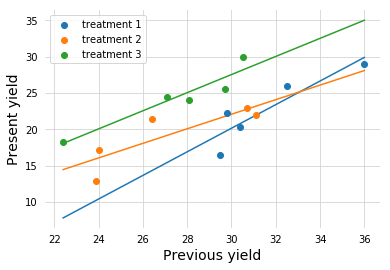

In [7]:
#dataframe of experimental data
data = pd.DataFrame({'treatment':[1] * 5 + [2] * 5 + [3] * 5,
                     'X':[29.5, 30.4, 29.8, 36, 32.5,
                          24, 26.4, 30.7, 31.1, 23.9,
                          22.4, 29.7, 30.5, 28.1, 27.1],
                     'Y':[16.5, 20.3, 22.2, 29, 26,
                          17.2, 21.4, 22.9, 22, 12.9,
                          18.3, 25.6, 30, 24, 24.5]})

#peform linear regression on data
slopes = [0] * 3
intercepts = [0] * 3
for i in range(1, 4):
    slopes[i - 1] = linregress(data[data['treatment']==i]['X'], data[data['treatment']==i]['Y'])[0]
    intercepts[i - 1] = linregress(data[data['treatment']==i]['X'], data[data['treatment']==i]['Y'])[1]
    
#get minimum and maximum values of X to plot regression lines
X_min = data['X'].min()
X_max = data['X'].max()

#plot data
fig, ax = plt.subplots()
for i in range(1, 4):
    ax.scatter(data[data['treatment']==i]['X'], data[data['treatment']==i]['Y'], label='treatment {}'.format(i), zorder=5)
    ax.plot([X_min, X_max], [j * slopes[i - 1] + intercepts[i - 1] for j in [X_min, X_max]], zorder=4)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.grid(color='lightgrey')
ax.tick_params(axis='both', color='white')
ax.set_xlabel('Previous yield', fontsize=14)
ax.set_ylabel('Present yield', fontsize=14)
plt.legend()

In [8]:
#==========================#
#=== degrees of freedom ===#
#==========================#

#total sample size
N = len(data)

#regression df
df_reg = 1

#treatment number and df
n_treat = len(set(data['treatment']))
df_treat = len(set(data['treatment'])) - 1

#total df
df_total = N - 1

#residual df
df_resid = df_total - df_treat - df_reg

#================================#
#=== common linear regression ===#
#================================#

#the values differ from what is in the book, see below
#determine regression parameters
b, a, _, _, _ = linregress(data['X'], data['Y'])

#fit Y values
fitted = data['X'] * b + a

#=======================#
#=== sums of squares ===#
#=======================#

#total sum of squares
total_ss = data['Y'].var() * (N - 1)

#regression sum of squares
reg_ss = np.sum((fitted - data['Y'].mean()) ** 2)

# I cannot find how to calculate the treatment sum of squares which is 101.460, the residual sum of squares is 53.291

#=========================#
#=== ANOVA table for Y ===#
#=========================#

#treatment sum of squares
treat_ss = data.groupby('treatment')['Y'].sum().var() * (n_treat - 1) / (N / n_treat)

#residual sum of squares
resid_ss = total_ss - treat_ss

#treatment mean square
treat_ms = treat_ss / df_treat

#residual mean square, we add 1 because we do not take regression into account here
resid_ms = resid_ss / (df_resid + 1)

#variance ratio for treatments
vr_treat = treat_ms / resid_ms

#p-value for treatments
p_Y = 1 - f.cdf(vr_treat, df_treat, df_resid + 1)

#=========================#
#=== ANOVA table for X ===#
#=========================#

#total sum of squares for X
total_ss_X = data['X'].var() * (N - 1)

#treatment sum of squares
treat_ss_X = data.groupby('treatment')['X'].sum().var() * (n_treat - 1) / (N / n_treat)

#residual sum of squares
resid_ss_X = total_ss_X - treat_ss_X

#treatment mean square
treat_ms_X = treat_ss_X / df_treat

#residual mean square, we add 1 because we do not take regression into account here
resid_ms_X = resid_ss_X / (df_resid + 1)

#variance ratio for treatments
vr_treat_X = treat_ms_X / resid_ms_X

#p-value for treatments
p_X = 1 - f.cdf(vr_treat_X, df_treat, df_resid + 1)

#==========================#
#=== print ANOVA tables ===#
#==========================#

print("Analysis of variance for Y\n")
print("{0:15}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}".format("Source", "df", "Sum sq", "Mean sq", "F-value", "p-value"))
print("-" * 65)
print("{0:15}{1:10}{2:10.2f}{3:10.2f}{4:10.3f}{5:10.5f}".format("Treatment", df_treat, treat_ss, treat_ms, vr_treat,
                                                                    p_Y))
print("{0:15}{1:10}{2:10.2f}{3:10.2f}".format("Residual", df_resid + 1, resid_ss, resid_ms))
print("{0:15}{1:10}{2:10.2f}\n\n".format("Total", df_total, total_ss))

print("Analysis of variance for X\n")
print("{0:15}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}".format("Source", "df", "Sum sq", "Mean sq", "F-value", "p-value"))
print("-" * 65)
print("{0:15}{1:10}{2:10.2f}{3:10.2f}{4:10.3f}{5:10.5f}".format("Treatment", df_treat, treat_ss_X, treat_ms_X, vr_treat_X,
                                                                    p_X))
print("{0:15}{1:10}{2:10.2f}{3:10.2f}".format("Residual", df_resid + 1, resid_ss_X, resid_ms_X))
print("{0:15}{1:10}{2:10.2f}\n\n".format("Total", df_total, total_ss_X))

Analysis of variance for Y

Source                 df    Sum sq   Mean sq   F-value   p-value
-----------------------------------------------------------------
Treatment               2     70.42     35.21     1.797   0.20769
Residual               12    235.16     19.60
Total                  14    305.58


Analysis of variance for X

Source                 df    Sum sq   Mean sq   F-value   p-value
-----------------------------------------------------------------
Treatment               2     60.50     30.25     3.055   0.08466
Residual               12    118.83      9.90
Total                  14    179.33




The small VR and large p-value in the Y ANOVA table indicate that unadjusted treatment means are not significantly different. The X table shows that the X means do not differ significantly between treatments, neither. We now test whether the treatment means after adjusting for a common X value are significantly different.

#### Interpretation of computer output (Minitab)

The inclusion of the covariate has reduced the residual sum of squares from 235.156 to 53.291, a reduction of 181.865. This change is significant (F=37.54, p=0.000), which indicates that the covariate was useful in increasing the precision of the treatment comparisons. It shows that 1.2371, the estimate of the assumed common slope, is significantly different from zero. The corresponding standard error is 0.2019 and the t-value of 1.2371 / 0.2019 = 6.13 (the square root of 37.54) provides an equivalent test.

The regression sum of squares obtained by fitting a regression line to all 15 points is 150.826 and after fitting parallel lines the regression sum of squares increases by 101.460. This increase is significant (F=10.47, p=0.003) indicating that a model with three parallel lines fits better than a model with a single line. This shows that the intercepts are significantly different assuming a common slope and hence that the adjusted treatment means (19.29, 21.24, 26.02) are significantly different. The standard errors of the adjusted treatment means are 1.139, 1.035 and 1.016.

We have shown that by taking into account the fertility of the plots, we have removed the effect of some treatments being applied to more fertile plots than others. The variation within treatments due to fertility has also been removed, thereby reducing the residual variation and allowing more precise treatment comparisons than if the covariate had not been used. The unadjusted residual mean square is 19.5963 and the adjusted value is 4.845. The ratio (4.04) is a measure of how much the covariate has improved the precision of the experiment.

## 5. Comparing several regression lines

To compare several regression lines we fit three models. In model 1, a single line is fitted and the residual sum of squares (ResidSS1) noted. In model 2, a common slope is estimated and separate parallel lines are fitted. The residual sum of squares (ResidSS2) for this model is the sum of the residual sum of squares for the separate fitted parallel lines. In model 3, separate lines are fitted and for each the residual sum of squares found. These are added to give the residual sum of squares (ResidSS3) for this model. It can be shown that ResidSS2 is always less than ResidSS1 and ResidSS3 is always less than ResidSS2. Hence a test of the hypothesis that the lines have equal slopes involves finding whether model 3 is significantly better than model 2. If it is, you would conclude the lines are not parallel. However, if the lines can be considered of equal slope you can then test whether they have equal intercepts. This test involves testing whether model 2 is a significantly better fit than model 1. If it is, you would conclude the intercepts are not equal. If it is not, you can assume equal intercepts and may use the overall regression line.

### 5.1 Model 1 : the overall line

ResidSS1 is 305.5773 - 150.8260 = 154.7513. As two parameters have been estimated (the intercept and the overall slope) the corresponding residual degrees of freedom are 15 - 2 = 13. The fitted equation of the overall line is Y = -4.2317 + 0.917X and $R^2 = 49.4\%$.

### 5.2 Model 3 : separate lines

Line 1 : Y1 = -28.5452 + 1.6228X1 $R^2 = 81.1\%$
Line 2 : Y2 = -7.9754 + 1.0013X2 $R^2 = 70.5\%$
Line 3 : Y3 = -9.8375 + 1.2452X3 $R^2 = 89.2\%$

Thus ResidSS3 = 17.9459 + 20.6719 + 7.5821 = 46.1999 (the sum of the residual sum of squares for each slope). As six parameters have been estimated (three intercepts and three slopes) the corresponding residual degrees of freedom are 15 - 6 = 9.

### 5.3 Model 2 : parallel lines

First we find $\hat{\beta}$, the estimate of the common slope $\beta$. This is a weighted average of the separate slopes, the weights being the Sxx values. It is the sum of the separate Sxy values divided by the sum of the separate Sxx values.

$$ \hat{\beta} = \frac{S_{xy1}+S_{xy2}+S_{xy3}}{S_{xx1}+S_{xx2}+S_{xx3}} = 1.2371 $$

We now assume parallel lines, so the three intercepts are estimated to be

$$ \hat{\alpha}_1 = \bar{Y}_1 - \hat{\beta} \bar{X}_1 = -16.3418 $$ 

$$ \hat{\alpha}_2 = \bar{Y}_2 - \hat{\beta} \bar{X}_2 = -14.3939 $$ 

$$ \hat{\alpha}_3 = \bar{Y}_3 - \hat{\beta} \bar{X}_3 = -9.6145 $$ 

For each line equation the fitted values can be found by substituting the X values. The residual are found by subtracting the fitted values from the Y values. The three residual sums of squares are found to be 22.2975, 23.4091 and 7.5847. These add to 53.2913 which is ResidSS2, the residual sum of squares after fitting model 2. As four parameters have been estimated (the three intercepts and the common slope), the corresponding residual degrees of freedom are 15 -4 = 11. Hence the mean square, denoted $s_{yx}^2$ is 53.2913 / 11 = 4.845. The value of ResidSS2 can be found directly as follows:

$$ ResidSS2 = \sum Syy - \left( \sum Sxy \right) ^2 / \sum Sxx $$

$\sum Syy$ is the residual sum of squares for Y values.
$\sum Sxx$ is the residual sum of squares for X values.

The standard error of the estimate of common slope is calculated as

$$ SE = \sqrt{\frac{s_{yx}^2}{\sum Sxx}} = \sqrt{\frac{4.845}{118.832}} = 0.2019 $$

In [9]:
#extracting X and Y values for each treatment for easier calculation
X1 = data[data['treatment']==1]['X']
X2 = data[data['treatment']==2]['X']
X3 = data[data['treatment']==3]['X']
Y1 = data[data['treatment']==1]['Y']
Y2 = data[data['treatment']==2]['Y']
Y3 = data[data['treatment']==3]['Y']

#calculation of sum of squares of X values
Sxx1 = X1.var() * (len(X1) - 1)
Sxx2 = X2.var() * (len(X2) - 1)
Sxx3 = X3.var() * (len(X3) - 1)

#calculation of sum of squares of products
Sxy1 = np.dot(X1, Y1) - X1.sum() * Y1.sum() / len(X1)
Sxy2 = np.dot(X2, Y2) - X2.sum() * Y2.sum() / len(X2)
Sxy3 = np.dot(X3, Y3) - X3.sum() * Y3.sum() / len(X3)

#calculation of sum of squares of Y values
Syy1 = Y1.var() * (len(X1) - 1)
Syy2 = Y2.var() * (len(X2) - 1)
Syy3 = Y3.var() * (len(X3) - 1)

#calculation of the common slope
slope_com = (Sxy1 + Sxy2 + Sxy3) / (Sxx1 + Sxx2 + Sxx3)

#intercepts
intercept1 = Y1.mean() - slope_com * X1.mean()
intercept2 = Y2.mean() - slope_com * X2.mean()
intercept3 = Y3.mean() - slope_com * X3.mean()

#residual sum of squares for model 2
resid_ss2 = Syy1 + Syy2 + Syy3 - (Sxy1 + Sxy2 + Sxy3) ** 2 / (Sxx1 + Sxx2 + Sxx3)

### 5.4 Testing the assumption of a common slope

ANCOVA is often carried out without first checking whether this assumption is reasonable. A X, Y plot of the data with different symbols for each treatment should always be obtained prior to analysis. The analysis is biaised if slopes are significantly different.

The test involves comparing model 2 (parallel slopes) with model 3 (separate lines). The reduction in the residual sums of squares due to fitting model 3 after model 2 is ResidSS2 - ResidSS3 = 53.2913 - 46.1999 = 7.0914. This reduction has 11 - 9 = 2 degrees of freedom. So the change mean square is 7.0914 / 2 = 3.5457 on 2 df. The residual mean square for model 3 is ResidSS3 / 9 = 5.1333. The F-value for testing the equality of slopes is obtained by dividing this change mean square by the mean square for model 3. Hence F = (7.0914 / 2) / (46.1999 / 9) = 0.69 on (2, 9) df. This is very small, so model 3 is not a significantly better fit than model 2, which implies that the assumption of a common slope is valid.

In the Seq SS column:
* 150.826 is the regression sum of squares after fitting model 1 (a single overall line). Hence the corresponding residual sum of squares is ResidSS1 = 305.577 - 150.826 = 154.751.
* 101.460 is the increase in the regression sum of squares due to fitting model 2 (parallel lines) after fitting model 1. It is also the decrease in the residual sum of squares (ResidSS1 - ResidSS2), where ResidSS2 = 305.577 - (150.826 + 101.460) = 53.291.
* 7.091 is the increase in the regression sum of squares due to fitting model 3 (separate lines) after fitting model 2. It is also the decrease in the residual sum of squares (ResidSS2 - ResidSS3).
* 46.200 is ResidSS3, the residual sum of squares after fitting model 3.

Finally, you should be aware that the above F-test requires the assumption that the residual variances about the individual fitted lines are not significantly different. They are given by the three residual mean squares (5.98, 6.89, 2.53) which can be obtained from the ResidSS values after dividing by (n - 2) = 3. As the largest ratio, 2.72 is much less than the 5% F-table value of 9.28 on (3, 3) df we can make the required assumption.

### 5.5 Comparing the slopes

If the slopes are found to be significantly different you may be interested in making pairwise comparisons. The criticisms of the LSD test also apply, you should make no more comparisons than one less than the number of lines. We have already shown that the slopes are not significantly different. However, we use the data from this example to illustrate the method of making pairwise slope comparisons when the slopes cannot be assumed equal. In general the SED value for comparing two slopes depends on which pair are being compared. For example, the SED for comparing slopes one and two is:

$$ \sqrt{s_p^2 \left( \frac{1}{S_{xx1}} + \frac{1}{S+{xx2}} \right)} = \sqrt{5.133\left( \frac{1}{29.252} + \frac{1}{49.228} \right)} = 0.529 $$

where $S_p^2 = 5.133$ is the pooled residual mean square for model 3, and can be found by adding the individual residual sums of squares and dividing by the sum of the residual degrees of freedom. Thus, $s_p^2 = ( 17.9459 + 20.6719 + 7.5821) / (3 + 3 + 3) = 46.1999 / 9 = ResidSS3 / 9$.

### 5.6 Testing th the assumption of equality of intercepts

If the slopes can be assumed equal as in this example the intercepts can be compared. This is done by comparing model 2 (the parallel slopes model) with model 1 (the single line model).

The reduction in the residual sums of squares due to fitting model 2 after model 1 is ResidSS1 - ResidSS2 = 154.751 - 53.291 = 101.460. This reduction has 13 - 11 = 2 df. So the change mean square is 101.460 / 2 = 50.730 on 2 df. The residual mean square for model 2 is ResidSS2 / 11 = $s_{yx}^2$ = 4.845.

The F-value for testing the equality of intercepts is obtained by dividing this change mean square by the mean square for model 2. Hence 

$$F = \frac{101.460\: / \: 2}{53.291 \: / \: 11} = \frac{50.730}{4.845} = 10.47 \: on \: (2, \: 11) \: df$$

This is the same as the F-test for comparing the adjusted treatment means. The standard errorof the adjusted treatment 1 mean (19.29) is 1.139.